## Import libraries

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import keras
# import gdown
import requests
import os
import yaml
import random
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import chi2_contingency
import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import LinearSVC
from itertools import product
from tqdm import tqdm
import pickle
# Set the seed for random function of python
random.seed(1)

## Load Dataset

In [ ]:
# # load gdbBinary.yaml
# with open("local-file-directory", "r") as f:
#     gdbBinary = yaml.safe_load(f)
# gdbBinary = gdbBinary["gdp_per_capita_index"]

# download y labels yaml file from github
url = "https://raw.githubusercontent.com/pleleGit/SatSenseAI/main/statistics/gdbBinary.yaml"
response = requests.get(url)

with open("gdbBinary.yaml", "wb") as f:
    f.write(response.content)

# load gdbBinary.yaml
with open("gdbBinary.yaml", "r") as f:
    gdbBinary = yaml.safe_load(f)

gdbBinary = gdbBinary["gdp_per_capita_index"]

In [ ]:
# # load gdbBinary.yaml
# with open("local-file-directory", "r") as f:
#     gdbRaw = yaml.safe_load(f)
# gdbRaw = gdbRaw["gdp_per_capita_index"]

# download y labels yaml file from github
url = "https://raw.githubusercontent.com/pleleGit/SatSenseAI/main/statistics/gdp.yaml"
response = requests.get(url)

with open("gdp.yaml", "wb") as f:
    f.write(response.content)

# load gdbBinary.yaml
with open("gdp.yaml", "r") as f:
    gdbRaw = yaml.safe_load(f)

gdbRaw = gdbRaw["gdp_per_capita_index"]

In [31]:
random.seed(1)

In [ ]:
# unzip fetched dataset (need to mount Drive)
!unzip -q /content/drive/MyDrive/VIIRS/bagsAugmented.zip -d /content/

In [ ]:
# load custom Bags dataset for training with Keras
train_bags = []
val_bags = []
test_bags = []
# dataset_path = "local-file-directory"
dataset_path = "/content/bagsAugmented"
instances_count = 50
train_bags_labels_binary = []
train_bags_labels_raw = []
val_bags_labels_binary = []
val_bags_labels_raw = []
test_bags_labels_binary = []
test_bags_labels_raw = []
countries = sorted(os.listdir(dataset_path))
years = sorted(os.listdir(os.path.join(dataset_path, countries[0])))
# remove b23 bag from years if exist (for consistency with latter results)
# (when this notebook created b23 was not available)
# if "b23" in years:
#     years.remove("b23")
print(f"Countries: {countries}")
print(f"Bags per year: {years}")
train_countries = random.sample(countries, 12)
for i, country in enumerate(countries):
    val_year = random.sample(years, 2)
    for year_bag in years:
        bag = []
        # Get the list of files
        all_files = os.listdir(os.path.join(dataset_path, country, year_bag))
        # Pick 30 random files without replacement
        selected_files = random.sample(all_files, instances_count)
        for img_path in selected_files:
            # Loads each image into PIL format
            img = keras.preprocessing.image.load_img(os.path.join(dataset_path, country, year_bag, img_path),
                                                    target_size=(300, 225),
                                                    color_mode="grayscale")
            # Converts a PIL Image instance to a NumPy array
            img_array = keras.preprocessing.image.img_to_array(img)
            img_array = img_array / 255.0  # standardize image to [0, 1]
            bag.append(img_array)
            if len(bag) == instances_count:
                break
        # collect the corresponding gdp per capita index
        id = int(year_bag[1:]) - 14
        if country in train_countries:
            if year_bag in val_year:
                val_bags.append(bag)
                val_bags_labels_binary.append([gdbBinary[country][id]])
                val_bags_labels_raw.append([gdbRaw[country][id]])
            else:
                train_bags.append(bag)
                train_bags_labels_binary.append([gdbBinary[country][id]])
                train_bags_labels_raw.append([gdbRaw[country][id]])
        else:
            test_bags.append(bag)
            test_bags_labels_binary.append([gdbBinary[country][id]])
            test_bags_labels_raw.append([gdbRaw[country][id]])
train_bags = np.squeeze(np.swapaxes(np.array(train_bags), 0, 1))
train_bags_labels_binary = np.array(train_bags_labels_binary)
train_bags_labels_raw = np.array(train_bags_labels_raw)
val_bags = np.squeeze(np.swapaxes(np.array(val_bags), 0, 1))
val_bags_labels_binary = np.array(val_bags_labels_binary)
val_bags_labels_raw = np.array(val_bags_labels_raw)
test_bags = np.squeeze(np.swapaxes(np.array(test_bags), 0, 1))
test_bags_labels_binary = np.array(test_bags_labels_binary)
test_bags_labels_raw = np.array(test_bags_labels_raw)

Countries: ['Albania', 'Austria', 'Belgium', 'Bosnia', 'Bulgaria', 'England', 'FYROM', 'France', 'Germany', 'Greece', 'Hungary', 'Italy', 'Montenegro', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Serbia', 'Spain']
Bags per year: ['b14', 'b15', 'b16', 'b17', 'b18', 'b19', 'b20', 'b21', 'b22', 'b23']


In [20]:
print("~~~~~~~~~~~ Stats for training set: ~~~~~~~~~~~")
print(f"Bags Shape: {train_bags.shape}")
print(f"Number of Bags: {train_bags.shape[1]}")
print(f"Number of Instances per Bag: {train_bags.shape[0]}")
print(f"Shape of each Instance: {train_bags.shape[2:]}")
print(f"Shape of Labels: {train_bags_labels_binary.shape}")
print("~~~~~~~~~~~ Stats for validation set: ~~~~~~~~~~~")
print(f"Bags Shape: {val_bags.shape}")
print(f"Number of Bags: {val_bags.shape[1]}")
print(f"Number of Instances per Bag: {val_bags.shape[0]}")
print(f"Shape of each Instance: {val_bags.shape[2:]}")
print(f"Shape of Labels: {val_bags_labels_binary.shape}")
print("~~~~~~~~~~~ Stats for test set: ~~~~~~~~~~~")
print(f"Bags Shape: {test_bags.shape}")
print(f"Number of Bags: {test_bags.shape[1]}")
print(f"Number of Instances per Bag: {test_bags.shape[0]}")
print(f"Shape of each Instance: {test_bags.shape[2:]}")
print(f"Shape of Labels: {test_bags_labels_binary.shape}")
train_bags = list(train_bags)
val_bags = list(val_bags)
test_bags = list(test_bags)

~~~~~~~~~~~ Stats for training set: ~~~~~~~~~~~
Bags Shape: (50, 96, 300, 225)
Number of Bags: 96
Number of Instances per Bag: 50
Shape of each Instance: (300, 225)
Shape of Labels: (96, 1)
~~~~~~~~~~~ Stats for validation set: ~~~~~~~~~~~
Bags Shape: (50, 24, 300, 225)
Number of Bags: 24
Number of Instances per Bag: 50
Shape of each Instance: (300, 225)
Shape of Labels: (24, 1)
~~~~~~~~~~~ Stats for test set: ~~~~~~~~~~~
Bags Shape: (50, 70, 300, 225)
Number of Bags: 70
Number of Instances per Bag: 50
Shape of each Instance: (300, 225)
Shape of Labels: (70, 1)


In [33]:
print(f"Positive / Negative Bags in train set: {np.sum(train_bags_labels_binary)} / {train_bags_labels_binary.shape[0] - np.sum(train_bags_labels_binary)}")
print(f"Positive / Negative Bags in validation set: {np.sum(val_bags_labels_binary)} / {val_bags_labels_binary.shape[0] - np.sum(val_bags_labels_binary)}")
print(f"Positive / Negative Bags in test set: {np.sum(test_bags_labels_binary)} / {test_bags_labels_binary.shape[0] - np.sum(test_bags_labels_binary)}")

Positive / Negative Bags in train set: 61 / 35
Positive / Negative Bags in validation set: 14 / 10
Positive / Negative Bags in test set: 35 / 35


## Features Extraction

In [34]:
np_train_bags = np.array(train_bags)
np_train_bags_labels = np.array(train_bags_labels_binary)

In [35]:
np_val_bags = np.array(val_bags)
np_val_bags_labels = np.array(val_bags_labels_binary)

In [36]:
np_test_bags = np.array(test_bags)
np_test_bags_labels = np.array(test_bags_labels_binary)

In [37]:
def extract_histogram(image, bins=64):
    hist, _ = np.histogram(image.flatten(), bins=bins)
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # Normalize
    return hist

In [38]:
def extract_bag_features(bag_images, bins=64, agg="mean"):
    histograms = [extract_histogram(img, bins) for img in bag_images]
    if agg == "mean":
        return np.mean(histograms, axis=0)
    elif agg == "max":
        return np.max(histograms, axis=0)
    elif agg == "concat":
        return np.concatenate(histograms)

In [39]:
def prepare_features(bags, labels, bins=64, agg="mean"):
    num_bags = bags.shape[1]
    X, y = [], []
    for i in range(num_bags):
        bag = bags[:, i, :, :]  # shape: (50, 300, 225)
        features = extract_bag_features(bag, bins, agg)
        X.append(features)
        y.append(labels[i][0])
    return np.array(X), np.array(y)

## Training

For our experiments we will try different number of histogram bins and different aggregation methods.

We will try:

- bins: [4, 8, 16, 32, 64]

- aggregation methods: ["mean", "max", "concat"]

At first we concatenate the training and validation sets that were used for the Neural Network Approaches into one single set. 

At first we train over this combined set on raw models without any fine tuning.

In [48]:
bins = [4, 8, 16, 32, 64]
aggregation_methods = ["mean", "max", "concat"]

# Store features and predictions
features_dict = {}
predictions_dict = {}

In [109]:
for bin, aggregation_method in tqdm(product(bins, aggregation_methods), total=len(bins)*len(aggregation_methods), desc="Processing combinations"):
    key = f"bin_{bin}-aggregationFunction_{aggregation_method}"
    X_train, y_train = prepare_features(np_train_bags, np_train_bags_labels, bins=bin, agg=aggregation_method)
    X_val, y_val = prepare_features(np_val_bags, np_val_bags_labels, bins=bin, agg=aggregation_method)
    X_test, y_test = prepare_features(np_test_bags, np_test_bags_labels, bins=bin, agg=aggregation_method)

    # Save features
    features_dict[key] = {
        "X_train": X_train,
        "y_train": y_train,
        "X_val": X_val,
        "y_val": y_val,
        "X_test": X_test,
        "y_test": y_test,
    }

    X_combined = np.concatenate([X_train, X_val])
    y_combined = np.concatenate([y_train, y_val])
    rf = RandomForestClassifier()
    svc = LinearSVC()
    dt = DecisionTreeClassifier()
    rf_model = rf.fit(X_combined, y_combined)
    svc_model = svc.fit(X_combined, y_combined)
    dt_model = dt.fit(X_combined, y_combined)
    rf_predictions = rf_model.predict(X_test)
    svc_predictions = svc_model.predict(X_test)
    dt_predictions = dt_model.predict(X_test)

    # Save predictions
    predictions_dict[key] = {
        "RandomForest": {
            "predictions": rf_predictions,
            "model": rf_model  # Optional: include the model object
        },
        "LinearSVC": {
            "predictions": svc_predictions,
            "model": svc_model  # Optional: include the model object
        },
        "DecisionTree": {
            "predictions": dt_predictions,
            "model": dt_model  # Optional: include the model object
        }
    }

Processing combinations:  13%|█▎        | 2/15 [00:16<01:42,  7.89s/it]c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
Processing combinations:  33%|███▎      | 5/15 [00:31<00:55,  5.58s/it]c:\Users\nikch\Documents\coding\SatSenseAI\tempVenv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
Processing combinations: 100%|██████████| 15/15 [01:23<00:00,  5.58s/it]


In [110]:
# Optional: Save everything to disk
with open("features_dict.pkl", "wb") as f:
    pickle.dump(features_dict, f)

with open("predictions_dict.pkl", "wb") as f:
    pickle.dump(predictions_dict, f)

In [ ]:
classification_reports = {}
confusion_matrices = {}

for key in predictions_dict:
    classification_reports[key] = {}
    confusion_matrices[key] = {}
    
    for model_name, model_data in predictions_dict[key].items():
        y_pred = model_data["predictions"]
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)
        
        classification_reports[key][model_name] = {
            "report": report
        }
        confusion_matrices[key][model_name] = {
            "confusionMatrix": cm
        }

In [112]:
with open("classification_reports.pkl", "wb") as f:
    pickle.dump(classification_reports, f)

with open("confusion_matrices.pkl", "wb") as f:
    pickle.dump(confusion_matrices, f)

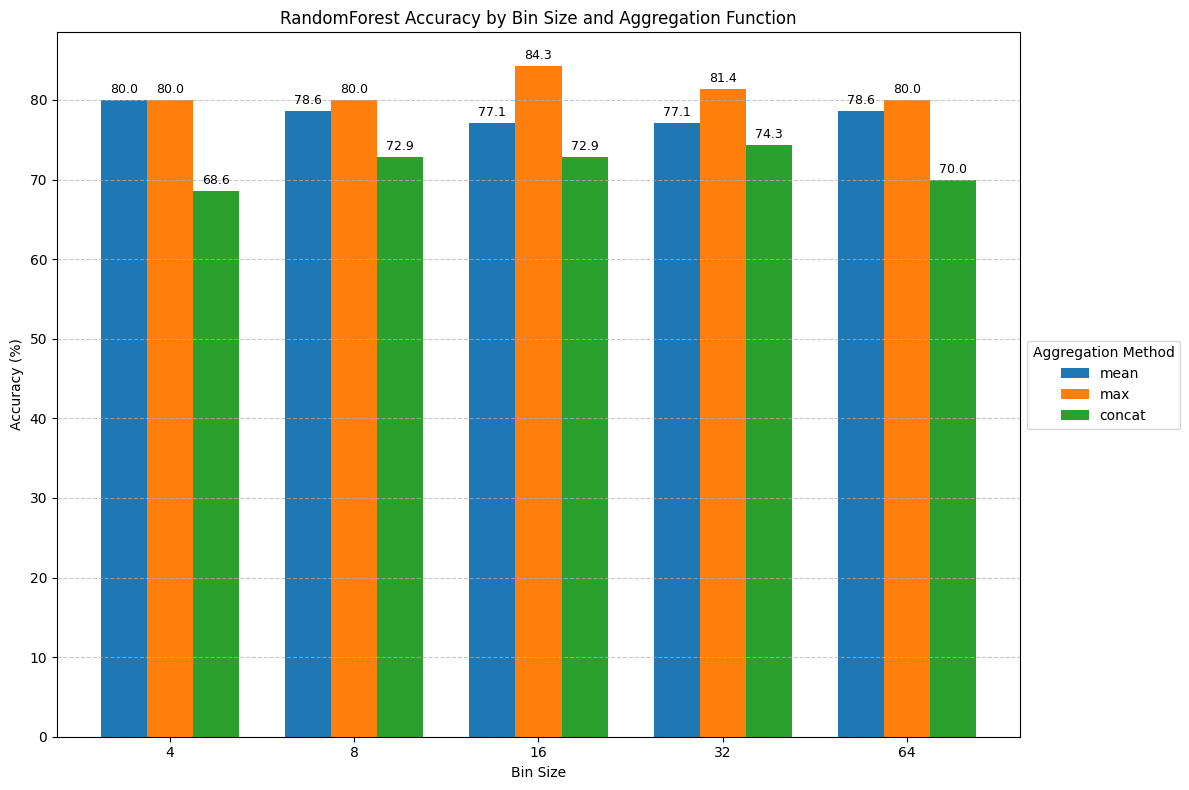

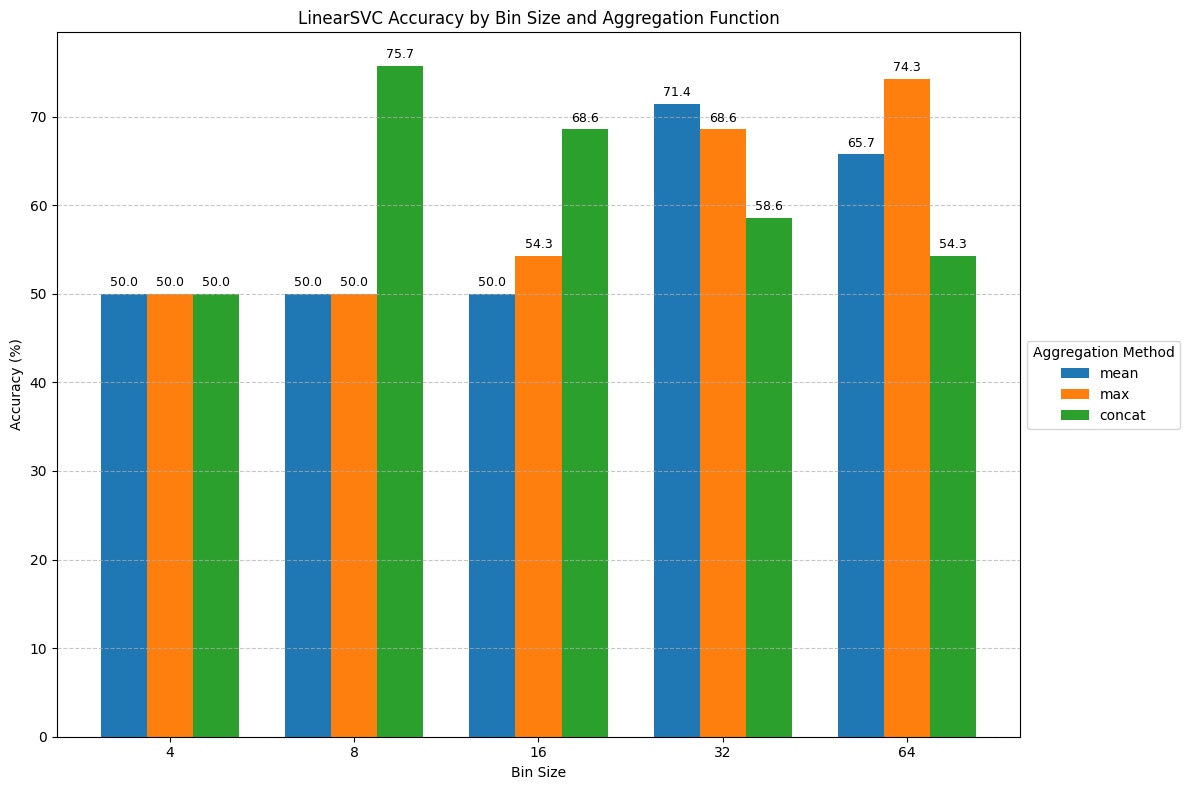

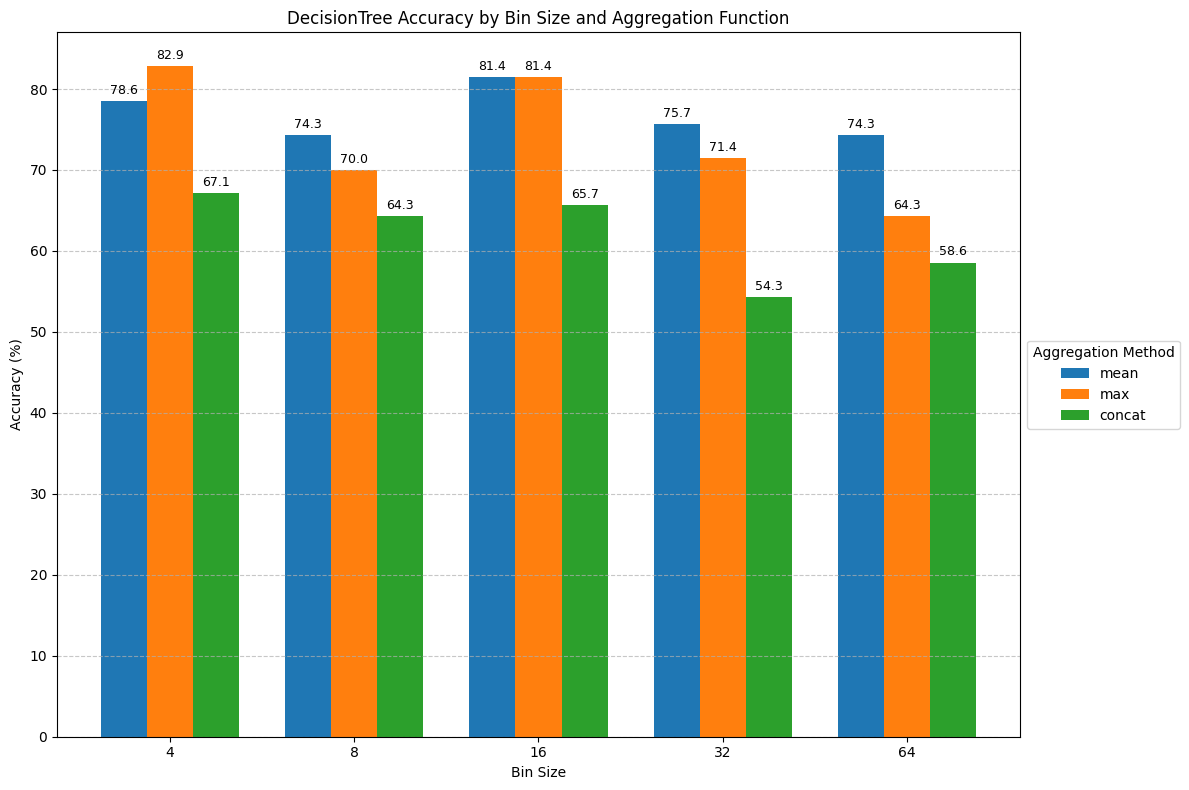

In [116]:
# Example inputs (replace with your real values)
bins = [4, 8, 16, 32, 64]
aggregation_methods = ["mean", "max", "concat"]
models = ["RandomForest", "LinearSVC", "DecisionTree"]

# Loop over models and generate one plot per model
for model in models:
    # Extract accuracy for this model grouped by aggregation method
    accuracies_by_agg = {
        agg: [
            classification_reports[f"bin_{b}-aggregationFunction_{agg}"][model]["report"]["accuracy"] * 100
            for b in bins
        ]
        for agg in aggregation_methods
    }

    # Plot settings
    bar_width = 0.25
    x = np.arange(len(bins))  # base x positions

    plt.figure(figsize=(12, 8))

    for i, agg in enumerate(aggregation_methods):
        bar_positions = x + i * bar_width
        accuracies = accuracies_by_agg[agg]
        bars = plt.bar(bar_positions, accuracies, width=bar_width, label=agg)
        
        # Add accuracy labels above bars
        for pos, acc in zip(bar_positions, accuracies):
            plt.text(pos, acc + 0.5, f"{acc:.1f}", ha='center', va='bottom', fontsize=9)

    # Formatting
    plt.xticks(x + bar_width, bins)
    plt.xlabel("Bin Size")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{model} Accuracy by Bin Size and Aggregation Function")
    plt.legend(title="Aggregation Method", loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()


Let's see the confusion matrix for the best perforing model.

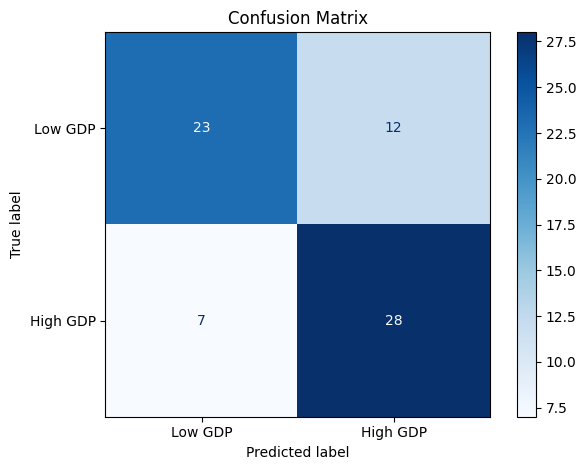

In [97]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low GDP", "High GDP"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In this stage we would like to check for the best performing model which bags have been misclassified.

To do so we would like to see the actual GDB values of these bags to check if they are near the boundary of classification (GBD = 70)

In [91]:
best_model_predictions = predictions_dict["bin_16-aggregationFunction_max"]["predictions"]
misclassified_bags = np.where(y_test != best_model_predictions)

In [103]:
test_bags_labels_raw.flatten()[misclassified_bags]

array([71, 66, 72, 74, 78, 41, 40, 40, 42, 44, 45, 46])